# Tech Challenge - Fase 1

## Análise e previsão de despesas médicas

O conjunto de dados de seguro médico abrange vários fatores que influenciam as despesas médicas, como idade, sexo, IMC, tabagismo, número de filhos e região. Este conjunto de dados serve de base para o treinamento de modelos de aprendizado de máquina capazes de prever despesas médicas para novos segurados.


# Itens abordados:

* 1 - Análise exploratória dos dados
* 2 - Regressao linear simples
* 3 - Modelo baseado em árvore (DecisionTreeRegressor)
  * 3.1 - Validação cruzada
  * 3.2 - Visualizando previsões
* 4 - Modelo baseado em árvore (RandomForestRegressor)
  * 4.1 - Validação cruzada
  * 4.2 - Visualizando previsões
  * 4.2 - Usando StandardScaler



# Base de dados

- A base de dados foi obtida do kaggle.com https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction?resource=download :


- **2772** registros
- Não há registros vazios
- **1435** linhas duplicadas
- Após a remoção das linhas duplicas **1337** linhas


# Atributos:

- **age**: idade

- **sex**: Sexo

- **bmi**: indice de massa corporal

- **children**: número de filhos

- **smoker**: fumante

- **region**: região

- **charges**: gasto com o plano de saúde

# 1 - Análise exploratória dos dados

In [300]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Necessário fazer o upload .csv

In [378]:
#dados = pd.read_csv("insurance.csv")
dados = pd.read_csv("medical_insurance.csv")

A planilha foi obtida do kaggle.com https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction?resource=download

In [367]:
dados.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [368]:
dados.shape

(1338, 7)

In [304]:
dados.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [305]:
dados

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
duplicados = dados.duplicated()
numero_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {numero_duplicados}")

linhas_duplicadas = dados[duplicados]
print(linhas_duplicadas)

Número de registros duplicados: 1435
      age     sex     bmi  children smoker     region      charges
581    19    male  30.590         0     no  northwest   1639.56310
1338   23    male  34.400         0     no  southwest   1826.84300
1339   56  female  39.820         0     no  southeast  11090.71780
1340   27    male  42.130         0    yes  southeast  39611.75770
1341   19    male  24.600         1     no  southwest   1837.23700
...   ...     ...     ...       ...    ...        ...          ...
2767   47  female  45.320         1     no  southeast   8569.86180
2768   21  female  34.600         0     no  southwest   2020.17700
2769   19    male  26.030         1    yes  northwest  16450.89470
2770   23    male  18.715         0     no  northwest  21595.38229
2771   54    male  31.600         0     no  southwest   9850.43200

[1435 rows x 7 columns]


In [ ]:
# Removendo duplicados (por padrão, mantém a primeira linha)
dados = dados.drop_duplicates()

# reindexando a base de dados
dados.reset_index(drop=True)

,age,sex,bmi,children,smoker,region,charges,bmi-types
0,19,0,27.900,0,1,3,16884.92400,2
1,18,1,33.770,1,0,2,1725.55230,3
2,28,1,33.000,3,0,2,4449.46200,3
3,33,1,22.705,0,0,1,21984.47061,1
4,32,1,28.880,0,0,1,3866.85520,2
...,...,...,...,...,...,...,...,...
1332,50,1,30.970,3,0,1,10600.54830,3
1333,18,0,31.920,0,0,0,2205.98080,3
1334,18,0,36.850,0,0,2,1629.83350,4
1335,21,0,25.800,0,0,3,2007.94500,2


In [306]:
dados.describe().T


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [307]:
dados.groupby('sex').describe()

age                                                         bmi  \
        count       mean        std   min   25%   50%    75%   max  count   
sex                                                                         
female  662.0  39.503021  14.054223  18.0  27.0  40.0  51.75  64.0  662.0   
male    676.0  38.917160  14.050141  18.0  26.0  39.0  51.00  64.0  676.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
sex                ...                                                     
female  30.377749  ...      2.0  5.0   662.0  12569.578844  11128.703801   
male    30.943129  ...      2.0  5.0   676.0  13956.751178  12971.025915   

                                                                     
              min        25%         50%           75%          max  
sex                                                                  
female  1607.5101  4885.1587  9412.96250  14454.691825  63770.42801  
male    1121.8739  4619.1340  9369.61575  18989.590250  62592.87309  

[2 rows x 32 columns]

In [308]:
dados.groupby('smoker').describe()

age                                                          bmi  \
         count       mean        std   min    25%   50%   75%   max   count   
smoker                                                                        
no      1064.0  39.385338  14.083410  18.0  26.75  40.0  52.0  64.0  1064.0   
yes      274.0  38.514599  13.923186  18.0  27.00  38.0  49.0  64.0   274.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
smoker             ...                                                     
no      30.651795  ...      2.0  5.0  1064.0   8434.268298   5993.781819   
yes     30.708449  ...      2.0  5.0   274.0  32050.231832  11541.547176   

                                                                          
               min           25%          50%           75%          max  
smoker                                                                    
no       1121.8739   3986.438700   7345.40530  11362.887050  36910.60803  
yes     12829.4551  20826.244213  34456.34845  41019.207275  63770.42801  

[2 rows x 32 columns]

In [309]:
dados.groupby('region').describe()

age                                                         bmi  \
           count       mean        std   min    25%   50%   75%   max  count   
region                                                                         
northeast  324.0  39.268519  14.069007  18.0  27.00  39.5  51.0  64.0  324.0   
northwest  325.0  39.196923  14.051646  19.0  26.00  39.0  51.0  64.0  325.0   
southeast  364.0  38.939560  14.164585  18.0  26.75  39.0  51.0  64.0  364.0   
southwest  325.0  39.455385  13.959886  19.0  27.00  39.0  51.0  64.0  325.0   

                      ... children      charges                              \
                mean  ...      75%  max   count          mean           std   
region                ...                                                     
northeast  29.173503  ...      2.0  5.0   324.0  13406.384516  11255.803066   
northwest  29.199785  ...      2.0  5.0   325.0  12417.575374  11072.276928   
southeast  33.355989  ...      2.0  5.0   364.0  14735.411438  13971.098589   
southwest  30.596615  ...      2.0  5.0   325.0  12346.937377  11557.179101   

                                                                          
                 min          25%           50%         75%          max  
region                                                                    
northeast  1694.7964  5194.322288  10057.652025  16687.3641  58571.07448  
northwest  1621.3402  4719.736550   8965.795750  14711.7438  60021.39897  
southeast  1121.8739  4440.886200   9294.131950  19526.2869  63770.42801  
southwest  1241.5650  4751.070000   8798.593000  13462.5200  52590.82939  

[4 rows x 32 columns]

In [310]:
dados.groupby('children').describe()

age                                                         bmi  \
          count       mean        std   min    25%   50%   75%   max  count   
children                                                                      
0         574.0  38.444251  16.436228  18.0  22.00  36.0  55.0  64.0  574.0   
1         324.0  39.453704  12.067445  18.0  30.00  40.0  49.0  64.0  324.0   
2         240.0  39.445833  11.588715  18.0  30.00  40.0  48.0  64.0  240.0   
3         157.0  41.566879  12.206174  18.0  31.00  41.0  52.0  64.0  157.0   
4          25.0  39.000000  12.138094  18.0  29.00  39.0  48.0  61.0   25.0   
5          18.0  35.611111  10.123583  19.0  28.75  39.0  42.5  52.0   18.0   

                     ...                  charges                              \
               mean  ...       75%    max   count          mean           std   
children             ...                                                        
0         30.550296  ...  34.74625  53.13   574.0  12365.975602  12023.293942   
1         30.623148  ...  34.23750  52.58   324.0  12731.171832  11823.631451   
2         30.978104  ...  35.35750  48.07   240.0  15073.563734  12891.368347   
3         30.684331  ...  34.32000  46.53   157.0  15355.318367  12330.869484   
4         31.391200  ...  33.66000  41.47    25.0  13850.656311   9139.223321   
5         29.605000  ...  33.05500  46.75    18.0   8786.035247   3808.435525   

                                                                          
                min          25%          50%           75%          max  
children                                                                  
0         1121.8739  2734.421150   9856.95190  14440.123825  63770.42801  
1         1711.0268  4791.643175   8483.87015  15632.052050  58571.07448  
2         2304.0022  6284.939438   9264.97915  20379.276748  49577.66240  
3         3443.0640  6652.528800  10600.54830  19199.944000  60021.39897  
4         4504.6624  7512.267000  11033.66170  17128.426080  40182.24600  
5         4687.7970  5874.973900   8589.56505  10019.943975  19023.26000  

[6 rows x 24 columns]

<Axes: xlabel='age', ylabel='Count'>

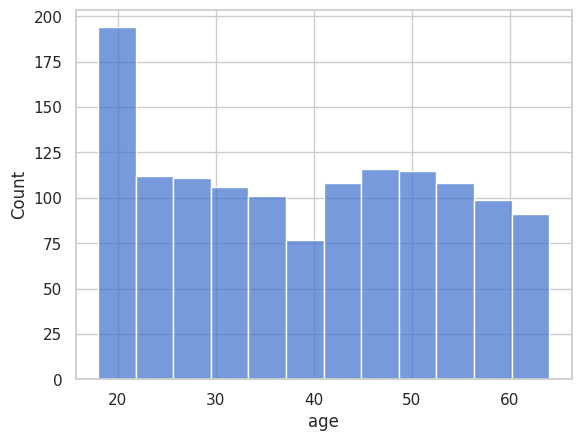

In [311]:
sb.histplot(data=dados, x="age")

<Axes: xlabel='children', ylabel='Count'>

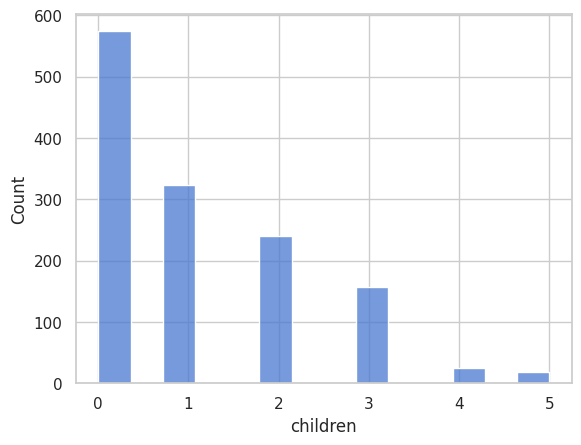

In [312]:
sb.histplot(data=dados, x="children")

<Axes: xlabel='bmi', ylabel='Count'>

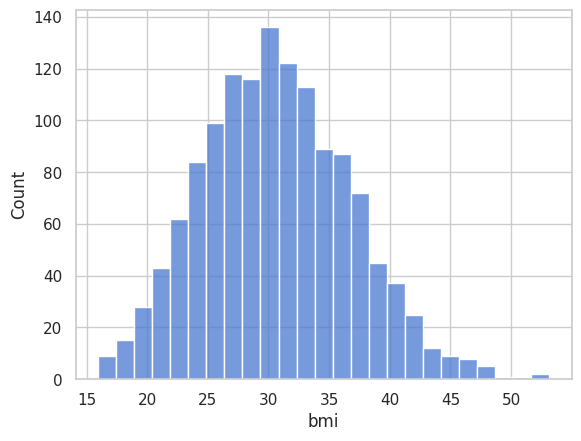

In [313]:
sb.histplot(data=dados, x="bmi")

<ipython-input-314-f53d60a028e2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='age', y='charges', data=dados, palette='hls')


<Axes: xlabel='age', ylabel='charges'>

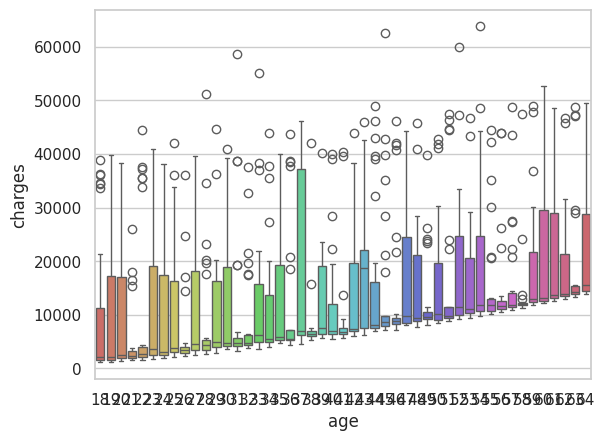

In [314]:
sb.boxplot(x='age', y='charges', data=dados, palette='hls')

**Obs:** Pode ser observado nesse gráfico, a relação da idade e dos gastos, que com o avanço da idade os gastos vão aumentando....

<Axes: xlabel='smoker', ylabel='charges'>

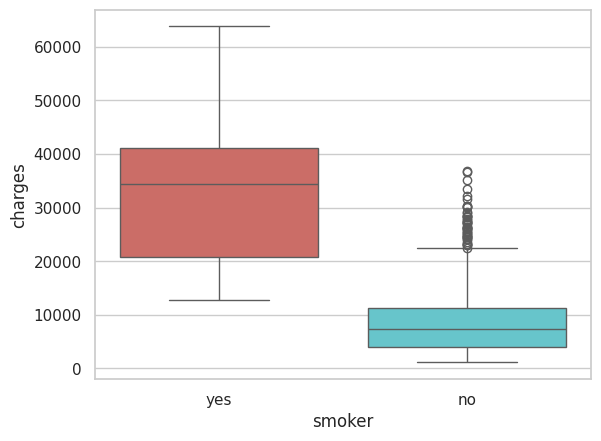

In [315]:
sb.boxplot(x='smoker', y='charges', hue='smoker', data=dados, palette='hls', legend=False)

**Obs:** Nesse gráfico pode ser observado que o fumante tem um gasto maior, em relação ao não fumante.

<Axes: xlabel='sex', ylabel='charges'>

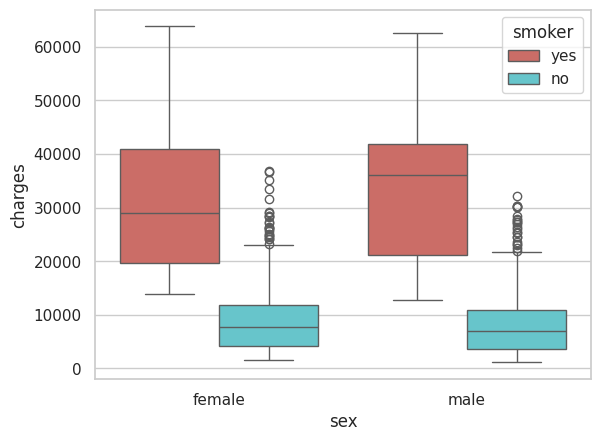

In [316]:

sb.boxplot(x='sex', y='charges', hue='smoker', data=dados, palette='hls', legend=True)

<Axes: xlabel='charges'>

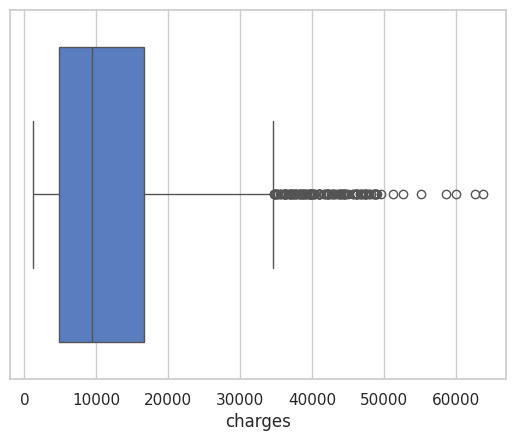

In [317]:
sb.boxplot(x=dados["charges"])

<Axes: xlabel='bmi'>

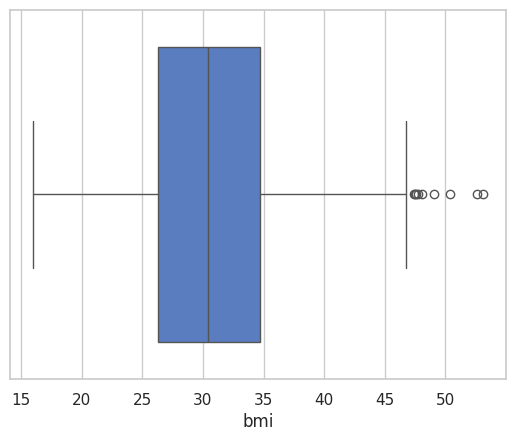

In [ ]:
sb.boxplot(x=dados["bmi"])

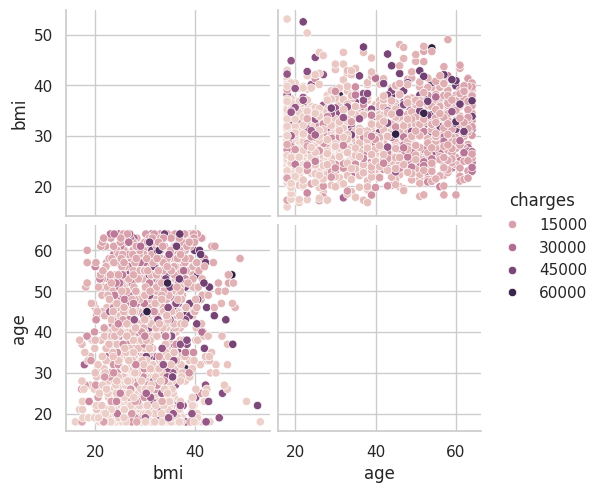

In [318]:
sb.pairplot(dados,vars=['bmi','age'],hue="charges")

**Obs:** Nesses gráficos, pode ser observar que quanto maior o bmi (indice de massa corportal) maior o gasto com o plano de saúde, o mesmo com  avanço da idade.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 20.0% of the points cannot be plac

[Text(13.000000000000002, 0.5, '')]

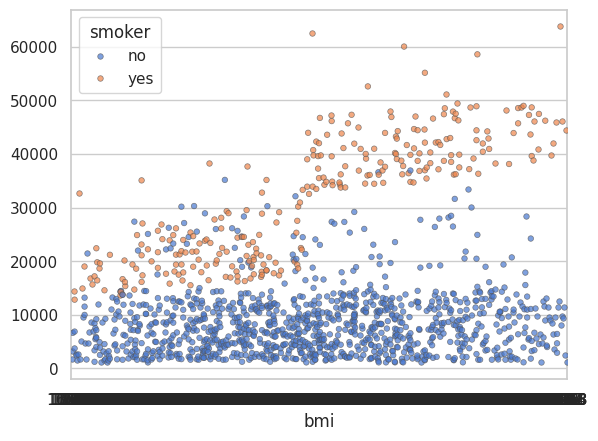

In [319]:
sb.set_theme(style="whitegrid", palette="muted")
ax = sb.swarmplot(data=dados, x="bmi", y="charges", hue="smoker",   size=4, linewidth=0.5,  alpha=0.7)
ax.set(ylabel="")

**Obs:** Aqui neste gráfico (smoker, bmi e charges), pode perceber que fumantes tem mais gastos com o plano de saude e quanto mais alto IMC o gasto vai aumentando


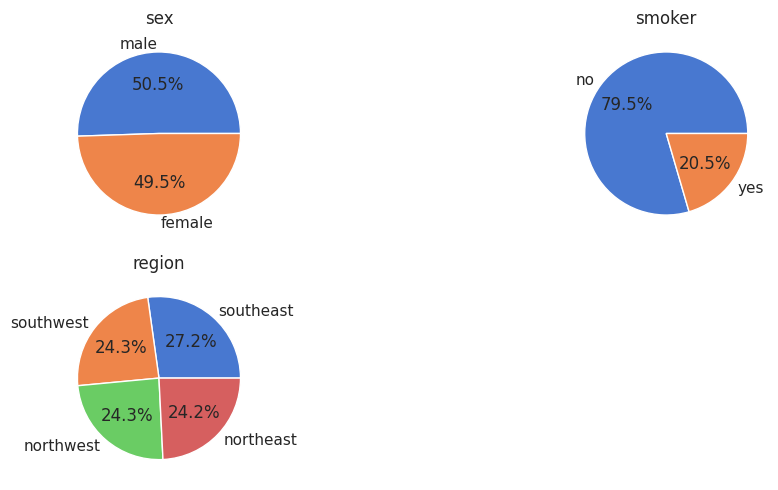

In [320]:
plt.figure(figsize=(12,9))
for i,col in enumerate(['sex','smoker','region']):
    plt.subplot(3,2,i+1)
    x=dados[col].value_counts().reset_index()
    plt.title(col)
    plt.pie(x=x['count'],labels=x[col],autopct="%0.1f%%",colors=sns.color_palette('muted'))

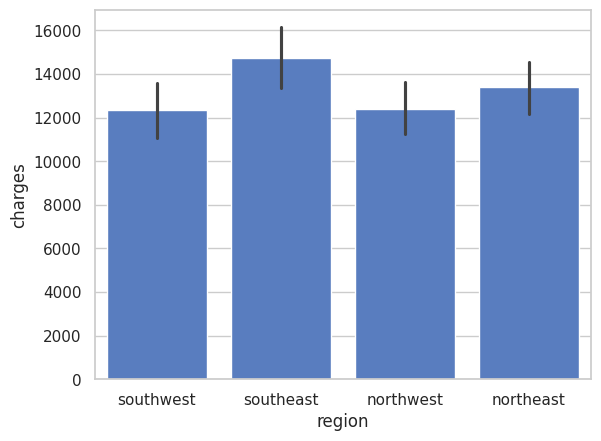

In [321]:
sns.barplot(data=dados,x=dados.region,y=dados.charges,estimator=np.mean)
plt.show()

# 1.1 - LabelEncoder

Vamos utilizar **label enconder** para tratar variáveis categóricas: **sex, smoker e region**

In [379]:
from sklearn.preprocessing import LabelEncoder

colunas=['sex','smoker','region']

label_encoder = LabelEncoder()
for col in colunas:
    dados[col] = label_encoder.fit_transform(dados[col])
    #dados.loc[:,col] = label_encoder.fit_transform(dados[col])

dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [380]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2772.0,39.109668,14.081459,18.0000,26.000,39.00000,51.0000,64.00000
sex,2772.0,0.507215,0.500038,0.0000,0.000,1.00000,1.0000,1.00000
bmi,2772.0,30.701349,6.129449,15.9600,26.220,30.44750,34.7700,53.13000
children,2772.0,1.101732,1.214806,0.0000,0.000,1.00000,2.0000,5.00000
smoker,2772.0,0.203463,0.402647,0.0000,0.000,0.00000,0.0000,1.00000
region,2772.0,1.532468,1.103467,0.0000,1.000,2.00000,2.0000,3.00000
charges,2772.0,13261.369959,12151.768945,1121.8739,4687.797,9333.01435,16577.7795,63770.42801


# 1.2 - Categorizando BMI

**`O índice de massa corporal ( IMC )`** é um valor derivado da massa ( peso ) e altura de uma pessoa. O IMC é definido como a massa corporal dividida pelo quadrado da altura corporal e é expresso em unidades de kg/m 2

IMC, categorias básicas Categoria	IMC (kg/m 2 )
- Abaixo do peso (magreza severa):	< 16,0
- Abaixo do peso (magreza moderada):	16,0 – 16,9
- Abaixo do peso (magreza leve):	17,0 – 18,4
- Intervalo normal:	18,5 – 24,9
- Excesso de peso (pré-obeso):	25,0 – 29,9
- Obeso (Classe I):	30,0 – 34,9
- Obeso (Classe II):	35,0 – 39,9
- Obeso (Classe III):	≥ 40,0


In [381]:
#dados.loc[:,"bmi-types"] = pd.cut(dados["bmi"],
dados["bmi-types"] = pd.cut(dados["bmi"],
                       bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                       labels=[1, 2, 3, 4, 5, 6]).cat.codes

dados['bmi-types']

0       2
1       3
2       3
3       1
4       2
       ..
2767    5
2768    3
2769    2
2770    1
2771    3
Name: bmi-types, Length: 2772, dtype: int8

In [371]:
print(dados)

      age  sex     bmi  children  smoker  region      charges  bmi-types
0      19    0  27.900         0       1       3  16884.92400          2
1      18    1  33.770         1       0       2   1725.55230          3
2      28    1  33.000         3       0       2   4449.46200          3
3      33    1  22.705         0       0       1  21984.47061          1
4      32    1  28.880         0       0       1   3866.85520          2
...   ...  ...     ...       ...     ...     ...          ...        ...
1333   50    1  30.970         3       0       1  10600.54830          3
1334   18    0  31.920         0       0       0   2205.98080          3
1335   18    0  36.850         0       0       2   1629.83350          4
1336   21    0  25.800         0       0       3   2007.94500          2
1337   61    0  29.070         0       1       1  29141.36030          2

[1338 rows x 8 columns]


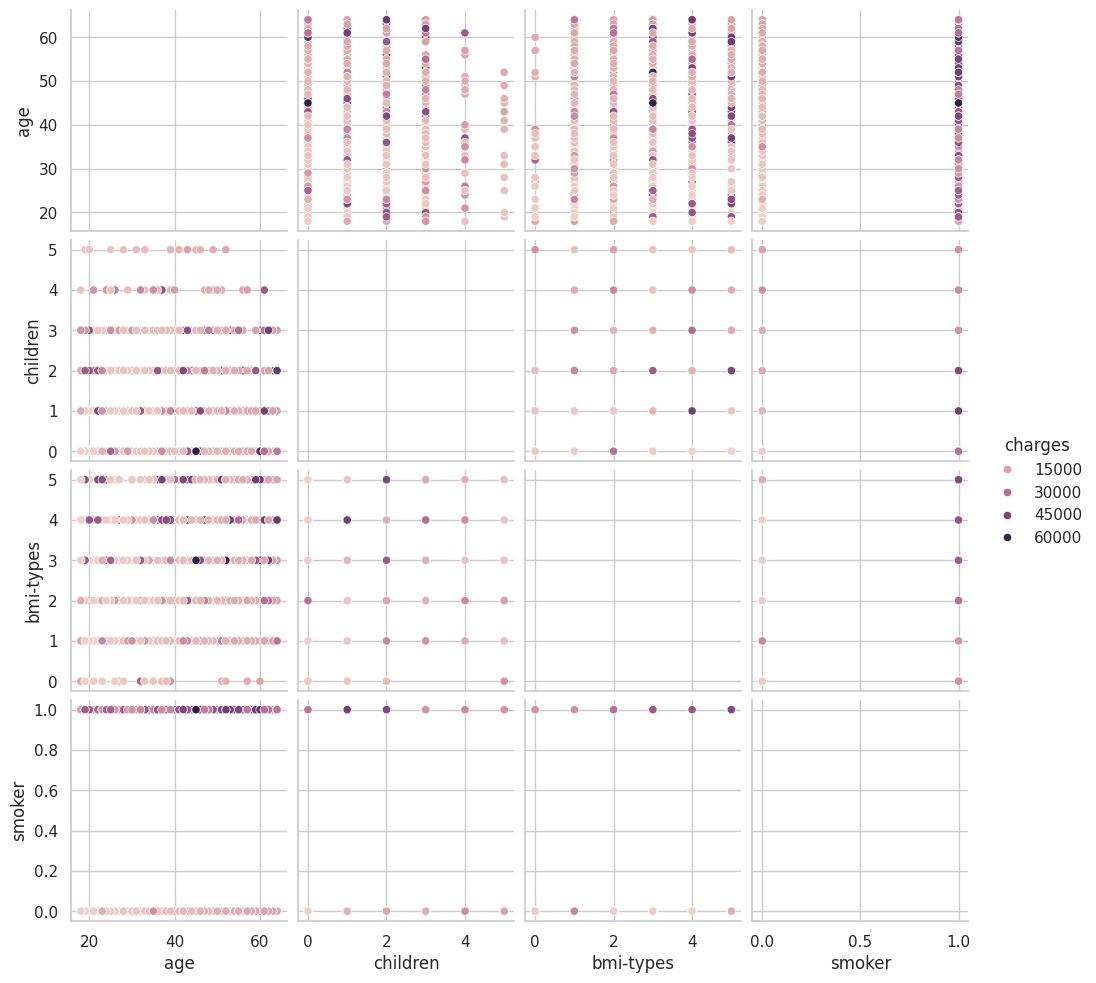

In [326]:
sb.pairplot(dados,vars=['age','children','bmi-types','smoker'],hue="charges")

# 1.3 - Correlações

<Axes: >

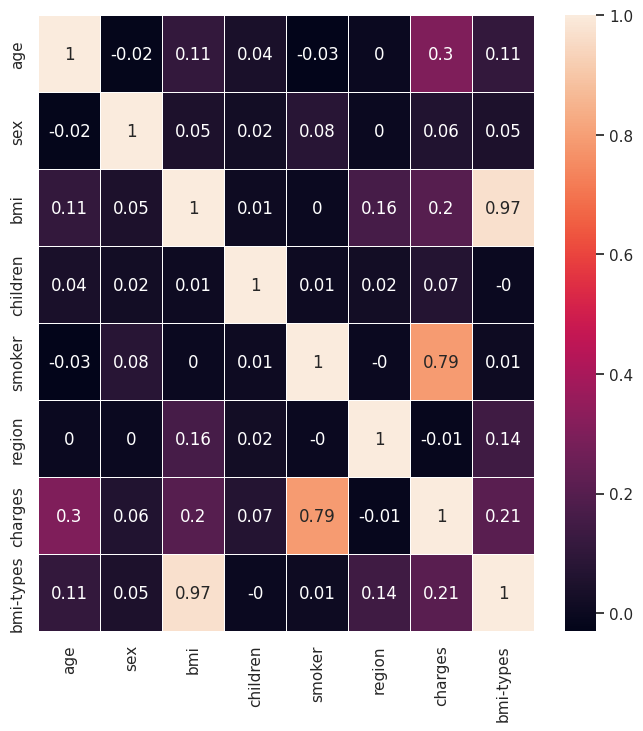

In [327]:
correlation_matrix = dados.corr().round(2)
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

**obs:** pode ser percebido que a correlação dos gastos com a pessoa fumante é alta de 0,78 e com bmi de 0,20 e de idade 0,29

In [337]:

correlation_matrix = dados.corr()
max_corr = correlation_matrix.stack().sort_values(ascending=False).drop_duplicates()
max_corr = max_corr[max_corr < 1].head(10)

print("Maiores correlações:")
print(max_corr)

Maiores correlações:
bmi-types  bmi          0.965013
smoker     charges      0.787251
charges    age          0.299008
           bmi-types    0.205401
           bmi          0.198341
region     bmi          0.157566
bmi-types  region       0.141961
age        bmi-types    0.113283
bmi        age          0.109272
smoker     sex          0.076185
dtype: float64


# Bases de treino e teste

- função para estratificação da base de treinamento e teste do modelo

In [344]:
from sklearn.model_selection import StratifiedShuffleSplit

def process_split_train_test(X, y, is_shuffle=True):

    if is_shuffle:
      print("Usando o ShuffleSplit em bmi-types")
      split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
      for train_index, test_index in split.split(X, X["bmi-types"]):
          shuffe_train = dados.loc[train_index]
          shuffe_test = dados.loc[test_index]

      # Removendo a coluna
      #for set_ in (shuffe_train, shuffe_test):
      #  set_.drop("bmi-types", axis=1, inplace=True)

      print("% base de treino -------------------")
      print(shuffe_train["bmi-types"].value_counts() / len(shuffe_train))

      print("% base de teste ---------------------")
      print(shuffe_test["bmi-types"].value_counts() / len(shuffe_test))

      X_train = shuffe_train.copy()
      y_train = X_train['charges'].copy()

      X_train = X_train.drop(columns=['charges'], axis=1)

      X_test = shuffe_test.copy()
      y_test = X_test['charges'].copy()

      X_test = X_test.drop(columns=['charges'], axis=1)
    else:
      print("Não usando o ShuffleSplit")
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, y_train, X_test, y_test

In [ ]:
X_train

,age,sex,bmi,children,smoker,region,bmi-types
2759,18,1,23.210,0,0,2,1
1599,34,0,26.730,1,0,2,2
1334,18,0,31.920,0,0,0,3
579,25,0,23.465,0,0,0,1
2664,39,1,29.925,1,1,0,3
...,...,...,...,...,...,...,...
440,31,0,32.680,1,0,1,3
50,18,0,35.625,0,0,0,4
45,55,1,37.300,0,0,3,4
1168,32,1,35.200,2,0,3,4


- Definindo os dados de X e y

In [345]:
y = dados['charges']

# usando bmi (sem categorização) e NÃO usando o ShuffleSplit
#X = dados[['age', 'sex', 'smoker', 'region', 'children','bmi']]
#X_train, y_train, X_test, y_test = process_split_train_test(X, y, False)

# usando bmi-types (categorizado) e NÃO usando o ShuffleSplit
#X = dados[['age', 'sex', 'smoker', 'region', 'children','bmi-types']]
#X_train, y_train, X_test, y_test = process_split_train_test(X, y, False)


# usando bmi-types (categorizado) e SUN usando o ShuffleSplit
X = dados[['age', 'sex', 'smoker', 'region', 'children','bmi-types']]
X_train, y_train, X_test, y_test = process_split_train_test(X, y, True)

Usando o ShuffleSplit em bmi-types
% base de treino -------------------
bmi-types
3    0.296262
2    0.284112
4    0.169159
1    0.165421
5    0.069159
0    0.015888
Name: count, dtype: float64
% base de teste ---------------------
bmi-types
3    0.298507
2    0.283582
4    0.167910
1    0.164179
5    0.070896
0    0.014925
Name: count, dtype: float64


- função de avaliação do modelo

In [346]:
def avalia_modelo(model, X_train, y_train, X_test, y_test, y_predito):
  print("Avaliando o desempenho do modelo")
  mse = mean_squared_error(y_test, y_predito)

  erro_absoluto_medio = mean_absolute_error(y_test, y_predito)
  r2 = r2_score(y_test, y_predito)

  print("Mean Squared Error:", mse)
  print(f'Erro Absoluto Médio: {erro_absoluto_medio}')
  print("R-squared:", r2)

  print()
  print("O score nos dá uma visão da precisão média da floresta aleatória nos dados")
  print("score train: ", model.score(X_train, y_train))
  print("score test: ", model.score(X_test, y_test))

- função de validação cruzada

In [347]:
from sklearn.model_selection import KFold, cross_val_score

def validacao_cruzada(model, k=10):
  print("")
  print("Validação cruzada k:", k)

  # Realize a validação cruzada e armazene os resultados em 'scores'
  scores = cross_val_score(model, X, y, cv=KFold(n_splits=k, shuffle=True, random_state=42))

  # Imprima a média e o desvio padrão das métricas
  print("K-Fold (R^2) Scores: {0}".format(scores))
  print("Desvio padrão do R²:", scores.std())
  print("Média do R²:", scores.mean())

# 2 - Regressao linear simples - - - - - - - - - - - - - - - - - - -


In [348]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [349]:
# Selecionando as features e o target

#X = dados[['age', 'bmi-types', 'sex', 'smoker', 'region', 'children']]
#X = dados[['age', 'bmi', 'sex', 'smoker', 'region', 'children']]
#y = dados['charges']

# Dividindo os dados em conjuntos de treino e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, y_train, X_test, y_test = process_split_train_test(dados)

# Criando um modelo de regressão linear
model = LinearRegression()

# Treinando o modelo
model.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
y_pred = model.predict(X_test)

avalia_modelo(model, X_train, y_train, X_test, y_test, y_pred)

validacao_cruzada(model)


Avaliando o desempenho do modelo
Mean Squared Error: 37690711.86795179
Erro Absoluto Médio: 4135.30720515682
R-squared: 0.750118772860588

O score nos dá uma visão da precisão média da floresta aleatória nos dados
score train:  0.7520458303720945
score test:  0.750118772860588

Validação cruzada k: 10
K-Fold (R^2) Scores: [0.7651544  0.79160372 0.73456582 0.74514158 0.81376642 0.77624551
 0.6602545  0.61624579 0.72986979 0.77969126]
Desvio padrão do R²: 0.05783045837963727
Média do R²: 0.7412538780581734


**Resultado**

Com o modelo  **LinearRegression** , usamos a primeiro a informação 'bmi' sem fazer a categorização que obteve um resultado de **73,98%**. Após fizemos uma categorização na coluna 'bmi' que obtivemos um resultado de **74,08%.** E depois usamos a técnica de ShuffleSplit para treinar o modelo nas faixas de BMI, onde tem uma melhora nos resultados **77,47%**

| bmi categories | ShuffleSplit | R-squared |
|---|---|---|
| Não | Não | 0.7398 |
| Sim | Não | 0.7408 |
| Sim | Sim | 0.7747 |


# 2.1 - Visualizando previsões

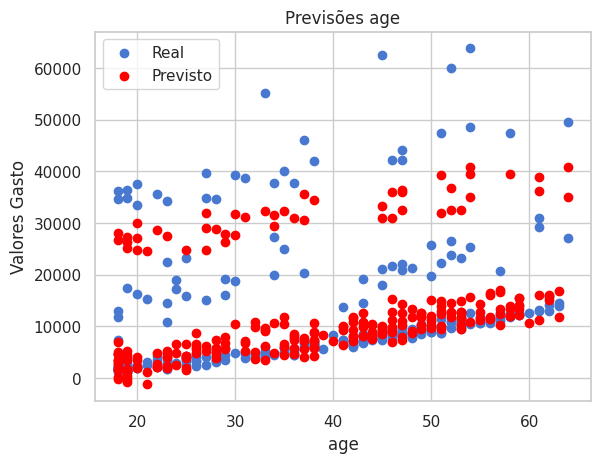

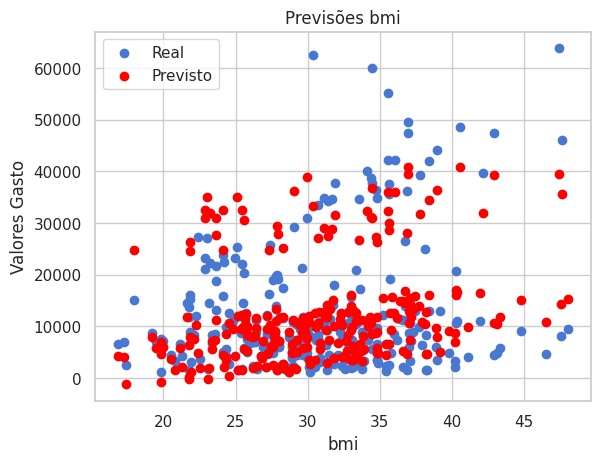

In [350]:

feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões age')
plt.legend()
plt.show()

feature = 'bmi'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões bmi')
plt.legend()
plt.show()

# 3 - Modelo baseado em árvore (DecisionTreeRegressor) - - - - - - - - - - - -



In [375]:
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn import tree

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

- Definindo X e y

In [376]:
y = dados['charges']

# usando bmi (sem categorização) e NÃO usando o ShuffleSplit
#X = dados[['age', 'sex', 'smoker', 'region', 'children','bmi']]
#X_train, y_train, X_test, y_test = process_split_train_test(X, y, False)

# usando bmi-types (categorizado) e NÃO usando o ShuffleSplit
#X = dados[['age', 'sex', 'smoker', 'region', 'children','bmi-types']]
#X_train, y_train, X_test, y_test = process_split_train_test(X, y, False)


# usando bmi-types (categorizado) e SUN usando o ShuffleSplit
X = dados[['age', 'sex', 'smoker', 'region', 'children','bmi-types']]
X_train, y_train, X_test, y_test = process_split_train_test(X, y, True)

Usando o ShuffleSplit em bmi-types
% base de treino -------------------
bmi-types
3    0.296262
2    0.284112
4    0.169159
1    0.165421
5    0.069159
0    0.015888
Name: count, dtype: float64
% base de teste ---------------------
bmi-types
3    0.298507
2    0.283582
4    0.167910
1    0.164179
5    0.070896
0    0.014925
Name: count, dtype: float64


In [377]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, y_train, X_test, y_test = process_split_train_test(dados)

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_predito = dt.predict(X_test)

y_predito = dt.predict(X_test)

# Avaliando o desempenho do modelo
avalia_modelo(dt, X_train, y_train, X_test, y_test, y_predito)

validacao_cruzada(dt)

Avaliando o desempenho do modelo
Mean Squared Error: 44110263.94011311
Erro Absoluto Médio: 3256.9310366007467
R-squared: 0.7075585379916627

O score nos dá uma visão da precisão média da floresta aleatória nos dados
score train:  1.0
score test:  0.7075585379916627

Validação cruzada k: 10
K-Fold (R^2) Scores: [0.71526185 0.75211454 0.67919487 0.65399204 0.74047726 0.71272874
 0.65239254 0.64088705 0.74309375 0.61175884]
Desvio padrão do R²: 0.04662715635413461
Média do R²: 0.6901901478807193


**Resultado**

Com o modelo  **DecisionTreeRegressor** , usamos a primeiro a informação 'bmi' sem fazer a categorização obteve um resultado de **94,99%**. Após fizemos uma categorização na coluna '**bmi**' que obtivemos um resultado de **92,41%.** E depois usamos a técnica de **ShuffleSplit** para treinar o modelo nas faixas de BMI, onde tem uma melhora nos resultados **95,34%**

| bmi categories | ShuffleSplit | R-squared |
|---|---|---|
| Não | Não | 0.9499 |
| Sim | Não | 0.9241 |
| Sim | Sim | 0.9534 |

O **score** nos dá uma visão da precisão média da floresta aleatória nos dados

# 3.1 - Validação cruzada

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# Defina o número de folds
k = 10

# Realize a validação cruzada e armazene os resultados em 'scores'
scores = cross_val_score(dt, X, y, cv=KFold(n_splits=k, shuffle=True, random_state=42))

# Imprima a média e o desvio padrão das métricas
print("K-Fold (R^2) Scores: {0}".format(scores))
print("Média do R²:", scores.mean())
print("Desvio padrão do R²:", scores.std())

K-Fold (R^2) Scores: [0.96418101 0.95330295 0.97960122 0.94816131 0.96012738 0.95620596
 0.94355272 0.95036027 0.92265263 0.97517955]
Média do R²: 0.9553325003661148
Desvio padrão do R²: 0.015401076652363906


# 3.2 - Visualizando as previsões

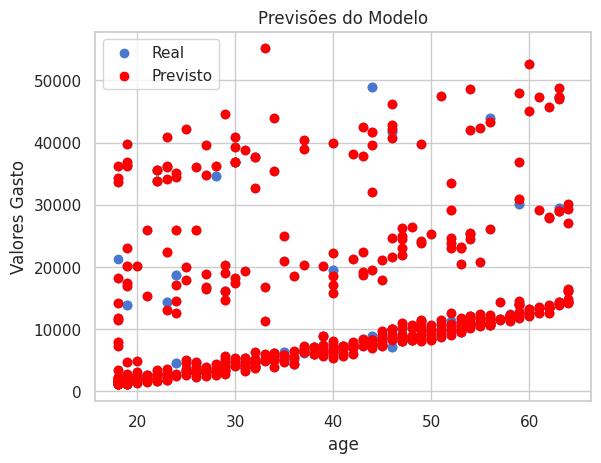

In [ ]:
feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_predito, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 4 - Modelo baseado em árvore (RandomForestRegressor) - - - - - - - - - - - - - -

- Definindo X e y

In [382]:
y = dados['charges']

# usando bmi (sem categorização) e NÃO usando o ShuffleSplit
#X = dados[['age', 'sex', 'smoker', 'region', 'children','bmi']]
#X_train, y_train, X_test, y_test = process_split_train_test(X, y, False)

# usando bmi-types (categorizado) e NÃO usando o ShuffleSplit
#X = dados[['age', 'sex', 'smoker', 'region', 'children','bmi-types']]
#X_train, y_train, X_test, y_test = process_split_train_test(X, y, False)


# usando bmi-types (categorizado) e SUN usando o ShuffleSplit
X = dados[['age', 'sex', 'smoker', 'region', 'children','bmi-types']]
X_train, y_train, X_test, y_test = process_split_train_test(X, y, True)

Usando o ShuffleSplit em bmi-types
% base de treino -------------------
bmi-types
3    0.294993
2    0.280559
4    0.170501
1    0.167343
5    0.071267
0    0.015336
Name: count, dtype: float64
% base de teste ---------------------
bmi-types
3    0.295495
2    0.281081
4    0.169369
1    0.167568
5    0.072072
0    0.014414
Name: count, dtype: float64


In [383]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_predito_random_forest = rf.predict(X_test)

# Avaliando o desempenho do modelo
avalia_modelo(rf, X_train, y_train, X_test, y_test, y_predito_random_forest)

validacao_cruzada(rf)

Avaliando o desempenho do modelo
Mean Squared Error: 4431461.244042481
Erro Absoluto Médio: 1112.6174135197293
R-squared: 0.9695305916880178

O score nos dá uma visão da precisão média da floresta aleatória nos dados
score train:  0.9923028555738399
score test:  0.9695305916880178

Validação cruzada k: 10
K-Fold (R^2) Scores: [0.95491294 0.94282809 0.95837274 0.93599482 0.96238347 0.94056774
 0.96069815 0.9445769  0.93698488 0.9698255 ]
Desvio padrão do R²: 0.011337274388285738
Média do R²: 0.9507145237969994


**Resultado**

Com o modelo  **RandomForestRegressor** , usamos a primeiro a informação 'bmi' sem fazer a categorização obteve um resultado de **94,99%**. Após fizemos uma categorização na coluna '**bmi**' que obtivemos um resultado de **92,41%.** E depois usamos a técnica de **ShuffleSplit** para treinar o modelo nas faixas de BMI, onde tem uma melhora nos resultados **95,10%**

| bmi categories | ShuffleSplit | R-squared |
|---|---|---|
| Não | Não | 0.9512 |
| Sim | Não | 0.9366 |
| Sim | Sim | 0.9695 |


# 4.2 - Vizualizando as previsões

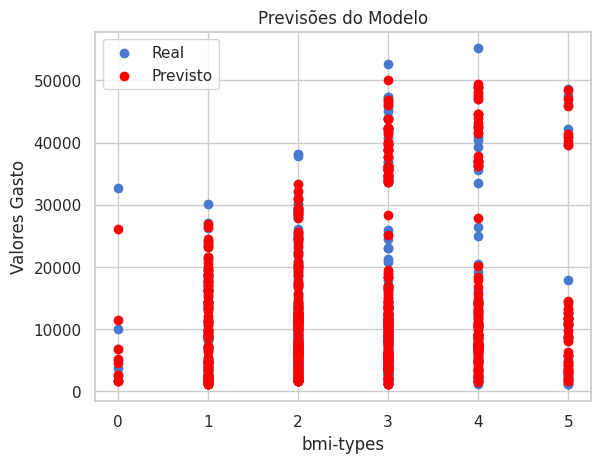

In [ ]:
feature = 'bmi-types'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_predito_random_forest, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 4.3 - Usando StandardScaler

In [361]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_predito_random_forest_scaled = rf.predict(X_test_scaled)

avalia_modelo(rf, X_train_scaled, y_train, X_test_scaled, y_test, y_predito_random_forest_scaled)

Avaliando o desempenho do modelo
Mean Squared Error: 23688198.69719844
Erro Absoluto Médio: 2886.751485572015
R-squared: 0.8429523915622497

O score nos dá uma visão da precisão média da floresta aleatória nos dados
score train:  0.9770474343881601
score test:  0.8429523915622497


**Obs:** Não há melhoras no modelo, usando StandardScaler